Importing plotly failed. Interactive plots will not work.


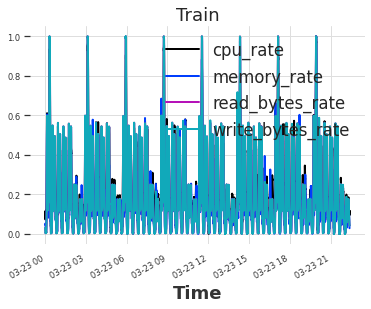

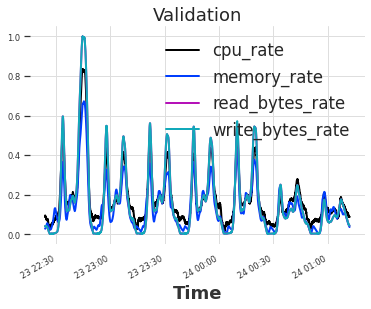

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
np.random.seed(seed)

import seaborn as sns

# Prettier plotting with seaborn
sns.set(font_scale=1.5)
# Ticks instead of whitegrid in order to demonstrate changes to plot ticks better
sns.set_style("ticks")

import pandas as pd
from darts.models import (
    BlockRNNModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/jupyter-babakesistani/adaptive-monitoring-nn/")
from pipeline.dataset.dataset_loader import DatasetLoader



dl =  DatasetLoader( '/home/jupyter-babakesistani/adaptive-monitoring-nn/pipeline/data/cpu_memory_disk_23_march.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    augment=False, resample_freq="1s", shift_df_datetime="2022-03-23 00:00:00")
scaled_one_day = 24*60
scaled_one_week = 7*24*60
idx_train = 8*scaled_one_week
idx_val = 9*scaled_one_week
train = dl.series_scaled[:idx_train]
val = dl.series_scaled[idx_train:idx_val]
    
train.plot()
plt.title("Train")

val.plot(new_plot=True)
plt.title("Validation")


def day_of_week(idxs):
    days = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) // (24*60)) % 7
    encoders = []
    for day in days:
        if day == 0:
            encoders.append(1)
        elif day == 1 or day == 2 or day == 3 or day == 4: 
            encoders.append(2)
        elif day == 5 or day == 6:
            encoders.append(3)
    return encoders

def minute_of_day(idxs):    
    minute_of_day = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) % (24*60))
    return minute_of_day



Text(0.5, 1.0, 'test')

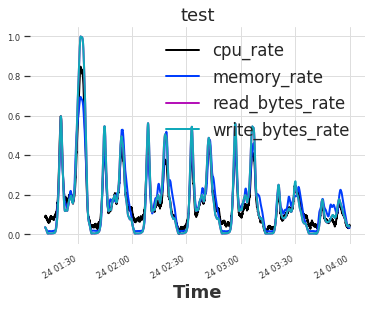

In [2]:
from darts import TimeSeries
dl_test =  DatasetLoader( '/home/jupyter-babakesistani/adaptive-monitoring-nn/pipeline/data/test_23_march.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    augment=False, resample_freq="1s", shift_df_datetime="2022-03-24 01:12:00")


test_df = dl_test.darts_df
test_series = TimeSeries.from_dataframe(test_df, dl_test.time_col, dl_test.target_cols)
test_series = dl.scaler.transform(test_series)

test = test_series
    
test.plot()
plt.title("test")


In [5]:
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
from darts.metrics import mape
# from darts import ModelMode
from enum import Enum


class ModelMode(Enum):
    MULTIPLICATIVE = "multiplicative"
    ADDITIVE = "additive"
    NONE = None


exp_model = ExponentialSmoothing(seasonal_periods=10080, trend=ModelMode.NONE, seasonal=ModelMode.NONE)
exp_model.fit(train['memory_rate'])
forecast = exp_model.predict(len(test['memory_rate']))
print("model {} obtains MAPE: {:.2f}%".format(exp_model, mape(test['memory_rate'], forecast['memory_rate'])))

model ExponentialSmoothing(trend=ModelMode.NONE, damped=False, seasonal=ModelMode.NONE, seasonal_periods=10080 obtains MAPE: 14.31%


<AxesSubplot:>

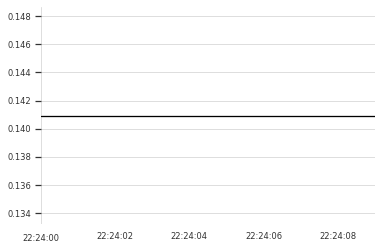

In [20]:
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train['memory_rate'].pd_dataframe())
alpha = 0.0001
expmodel = ses.fit(smoothing_level = alpha, optimized = False)
forcast = expmodel.forecast(10)
forcast.plot()

<AxesSubplot:>

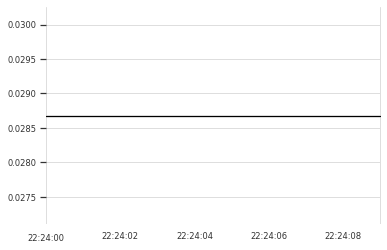

<AxesSubplot:>

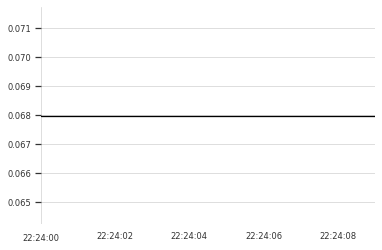

In [11]:
train['memory_rate'].pd_dataframe()

component,memory_rate
Time,
2022-03-23 00:00:00,0.046465
2022-03-23 00:00:01,0.046566
2022-03-23 00:00:02,0.046561
2022-03-23 00:00:03,0.046726
2022-03-23 00:00:04,0.046902
...,...
2022-03-23 22:23:55,0.029324
2022-03-23 22:23:56,0.029062
2022-03-23 22:23:57,0.028939
